# Primitive model of electrolytes: NaCl in continuum solvent

In this example we explore the possibility for setting a background dielectric constant for simulating (soft) particles in an implicit solvent.

- Can $\epsilon_r$ be set for PME/Ewald? Nothing found in the documentation so far except for scaling charges
- Use a custom nonbonded ff instead?
- GBSA forces are automatically added when a `<GBSAOBCForce>` section is encountered in .xml file
- For ideas for rigid bodies, see openmm forum: https://simtk.org/forums/viewtopic.php?f=161&t=5841&p=14836&hilit=rigid#p14836

In [1]:
%matplotlib inline
from __future__ import print_function
from simtk.openmm import app
import simtk.openmm as mm
from simtk import unit
from sys import stdout, exit
import numpy as np
import math
import mdtraj as mdtraj

cutoff           = 50*unit.angstrom
temperature      = 300*unit.kelvin
useMinimize      = False
epsilon_r        = 80.
steps_eq         = 5000
steps_production = 4e5

pdb = app.PDBFile('nacl.pdb')
forcefield = app.ForceField('cg.xml')

system = forcefield.createSystem(pdb.topology, nonbondedMethod=app.Ewald, 
                nonbondedCutoff=cutoff, ewaldErrorTolerance=0.1)

# scale charges
def scaleCharges(system, scale=1.0):
    """
    Scale charges in all appropriate force classes of system. This can
    be used to simulate a system with a different background dielectric
    by setting scale=1/sqrt(epsilon_r), for example.
    """
    for force in system.getForces():
        if 'getParticleParameters' in dir(force):
            for i in range(force.getNumParticles()):
                charge, sigma, epsilon = force.getParticleParameters(i)
                force.setParticleParameters(i, scale*charge, sigma, epsilon)
        if 'getExceptionParameters' in dir(force):
            for i in range(force.getNumExceptions()):
                p1, p2, chargeProd, sigma, epsilon = force.getExceptionParameters(i)
                force.setExceptionParameters(i, p1, p2, chargeProd*(scale**2), sigma, epsilon)
    
scaleCharges(system, scale=1/math.sqrt(epsilon_r))

# set dielectric constant (no effect on pairwise-interactions)
for i in system.getForces():
  if isinstance(i, mm.NonbondedForce):
    i.setReactionFieldDielectric(epsilon_r)
    print ('RF dielectric = ', i.getReactionFieldDielectric())
    
integrator = mm.LangevinIntegrator(
    temperature,
    1.0/unit.picoseconds, 
    20.0*unit.femtoseconds)

integrator.setConstraintTolerance(0.00001)

simulation = app.Simulation(pdb.topology, system, integrator)
simulation.context.setPositions(pdb.positions)

if useMinimize:
  print('Minimizing...')
  simulation.minimizeEnergy()

print('Equilibrating...')
simulation.context.setVelocitiesToTemperature(300*unit.kelvin)
simulation.step(steps_eq)

steps_total = steps_eq + steps_production
simulation.reporters.append(mdtraj.reporters.HDF5Reporter('trajectory.h5', 100))
simulation.reporters.append(app.PDBReporter('trajectory.pdb', 1000))
simulation.reporters.append(app.StateDataReporter(stdout, int(steps_total/10), step=True, 
    potentialEnergy=True, temperature=True, progress=True, remainingTime=False, 
    speed=True, totalSteps=steps_total, volume=True, separator='\t'))

print('Production...')
simulation.step(steps_production)

print('Done!')

RF dielectric =  80.0
Equilibrating...
Production...
#"Progress (%)"	"Step"	"Potential Energy (kJ/mole)"	"Temperature (K)"	"Box Volume (nm^3)"	"Speed (ns/day)"
10.0%	40500	-9.41419052737	389.559018631	1000.0	0
20.0%	81000	-5.38719238931	323.348955062	1000.0	5.51e+03
30.0%	121500	-13.2359821502	358.396576464	1000.0	5.5e+03
40.0%	162000	-10.0617166891	256.047483629	1000.0	5.49e+03
50.0%	202500	-9.76001213709	312.319746817	1000.0	5.39e+03
60.0%	243000	-10.6731361359	308.124138624	1000.0	5.41e+03
70.0%	283500	-9.8400834653	432.585410388	1000.0	5.42e+03
80.0%	324000	-17.2790620144	255.991047233	1000.0	5.43e+03
90.0%	364500	-14.271373764	273.278255592	1000.0	5.43e+03
100.0%	405000	-19.5669405017	305.142845317	1000.0	5.43e+03
Done!


### Plot and compare with Debye-Hückel

Calculate the radial distribution function, $g(r)=\exp\left(-w(r)/k_BT\right)$, between Na+ and Cl- and compare
the result with the Debye-Hückel potential for the interaction free energy between two ions in an aqueous salt solution,

\begin{equation}
w(r) / k_BT = \frac{\lambda_Bz_1z_2}{r}e^{-r/\lambda_D}
\end{equation}

where
$\lambda_B=e^2/4\pi\epsilon_0\epsilon_rk_BT$ and
$\lambda_D=(4\pi\lambda_B\sum \rho_iz_i^2)^{-1/2}$ are the Bjerrum and Debye lengths, respectively. $\rho_i$ is the number density of the $i$th ion.

Salt concentration =  0.019926465398 M
Bjerrum length     =  0.696253115266 nm
Debye length       =  2.18225688043 nm


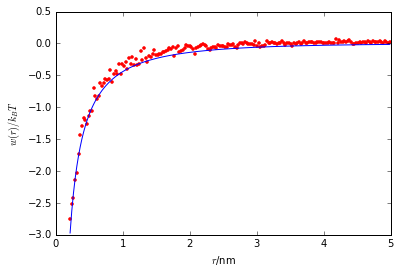

In [2]:
import matplotlib
import matplotlib.pyplot as plt

# volume, conc., bjerrum & debye length
epsilon_0 = 8.8541878176e-12*unit.farad/unit.meter
N         = simulation.system.getNumParticles()
V         = simulation.topology.getUnitCellDimensions()[0]**3
lB        = (unit.elementary_charge**2 /
            (4*math.pi*epsilon_0*epsilon_r*unit.BOLTZMANN_CONSTANT_kB*temperature))\
            .in_units_of(unit.nanometer)
lD        = 1/unit.sqrt(4*math.pi*lB*N/V)

print('Salt concentration = ', 0.5*(N/unit.AVOGADRO_CONSTANT_NA/V).in_units_of(unit.molar))
print('Bjerrum length     = ', lB)
print('Debye length       = ', lD)

# open trajectory and plot rdf
simulation.reporters[0].close()
traj = mdtraj.load('trajectory.h5')
r,g = mdtraj.compute_rdf(traj, traj.topology.select_pairs('name Na', 'name Cl'),\
                         r_range=[0.2,5], bin_width=0.025)
r=r*unit.nanometer

# plot simulated Na-Cl pmf (red) vs. Debye-Huckel (blue)
plt.xlabel('$r$/nm')
plt.ylabel('$w(r)/k_BT$')
plt.plot(r, -np.log(g), 'r.')
plt.plot(r, -lB / r * np.exp( -r/lD ), 'b-')